# Подход к отсеиванию некачественных фотографий

Первая проверка до детекции прутков: отсеиваем фотографии с сильным засветом и нечёткие изображения.

Вторая проверка после детекции: отсеиваем изображения, на которых
- прутков очень много
- их нет совсем
- прутки сфотографированы частично и находятся на краях фотографии.

Третья проверка (локальная) на выделенных детекцией bounding box-ах: отсеиваем
- сильный засвет
- нечёткость
- прутки малой площади
- прутки, слишком сильно повёрнутые относительно положения: изображение их торца не совпадает с поперечным сечением бруска 
- прутки, на которых невозможно распознать цифры

На всех проверках будем собирать отрицательные примеры, считать квантили для значений метрик на этих примерах. А затем отсеивать изображения по посчитанным квантилям

# Первая проверка до детекции

## Сильный засвет

В этом блоке решающей метрикой будет средняя яркость по изображению.

Нагенерируем отрицательные примеры при помощи аугментации:

In [1]:
import random
import os

import cv2
from matplotlib import pyplot as plt
import numpy as np

import albumentations as A

CURR_DIR = os.getcwd()

In [2]:
def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)

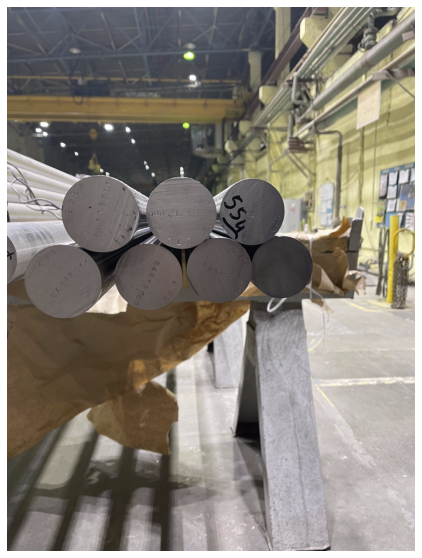

In [3]:
image = cv2.imread(os.path.join(CURR_DIR, 'img_examples/global_highlights/positive/IMG_1748.png'))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image)

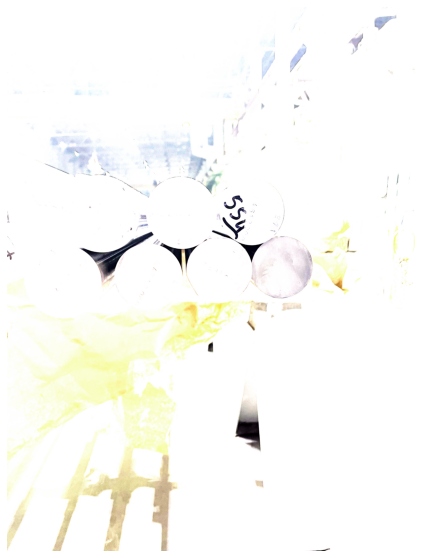

In [4]:
transform = A.ColorJitter(brightness=(5, 6))
random.seed(7)
augmented_image = transform(image=image)['image']
visualize(augmented_image)

In [5]:
from tqdm.notebook import tqdm

POS_PATH = os.path.join(CURR_DIR, 'img_examples/global_highlights/positive')
NEG_PATH = os.path.join(CURR_DIR, 'img_examples/global_highlights/negative')

for img in tqdm(os.listdir(POS_PATH)):
    curr_image = cv2.imread(os.path.join(POS_PATH, img))
    for i in [1, 3, 7]:
        random.seed(i)
        augmented_image = transform(image=curr_image)['image']
        cv2.imwrite(os.path.join(NEG_PATH, img + '_' + str(i)), augmented_image)

  0%|          | 0/71 [00:00<?, ?it/s]

Теперь посчитаем среднюю яркость на полученных "плохих" изображениях:

In [6]:
negative_intensities = np.zeros(len(os.listdir(NEG_PATH)))

for i, img in tqdm(enumerate(os.listdir(NEG_PATH))):
    image = cv2.imread(os.path.join(NEG_PATH, img))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    intensity = gray / 255
    mean_intensity = np.mean(intensity)
    negative_intensities[i] = mean_intensity
    
positive_intensities = np.zeros(len(os.listdir(POS_PATH)))

for i, img in tqdm(enumerate(os.listdir(POS_PATH))):
    image = cv2.imread(os.path.join(POS_PATH, img))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    intensity = gray / 255
    mean_intensity = np.mean(intensity)
    positive_intensities[i] = mean_intensity

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [7]:
def print_statistics(array):
    print('Min: %.3f, Max: %.3f' % (np.min(array), np.max(array)))
    print('Mean: %.3f' % np.mean(array))
    print('0.02-quantile: %.3f, median: %.3f, 0.98-quantile: %.3f' % (np.quantile(array, 0.02), np.quantile(array, 0.5), np.quantile(array, 0.98)))

In [8]:
print('Positive examples:')
print_statistics(positive_intensities)
print('Negative examples:')
print_statistics(negative_intensities)

Positive examples:
Min: 0.291, Max: 0.559
Mean: 0.479
0.02-quantile: 0.380, median: 0.480, 0.98-quantile: 0.550
Negative examples:
Min: 0.746, Max: 0.999
Mean: 0.951
0.02-quantile: 0.804, median: 0.964, 0.98-quantile: 0.999


Итоговая проверка будет выглядеть так:

In [9]:
def global_highlight(gray_img: np.ndarray) -> bool:
    "returns True, if image is too bright"
    
    intensity = gray_img / 255
    mean_intensity = np.mean(intensity)
    return mean_intensity > 0.804

## Нечёткость

В этой части нам могут помочь метрики, связанные с разбросом яркости, а именно выборочная дисперсия, STA6 (считает среднее по квадратам разностей между средней яркостью в окрестности и яркостью центрального в окрестности пикселя) и CONT (среднее по суммам разностей центрального пиксела и каждого из соседних пикселей).

Сначала вновь построим отрицательные примеры:

In [10]:
POS_PATH = os.path.join(CURR_DIR, 'img_examples/global_blurriness/positive')
NEG_PATH = os.path.join(CURR_DIR, 'img_examples/global_blurriness/negative')

Часть отберём из нашего датасета (4 фотографии)

А также добавим примеров с помощью аугментаций:

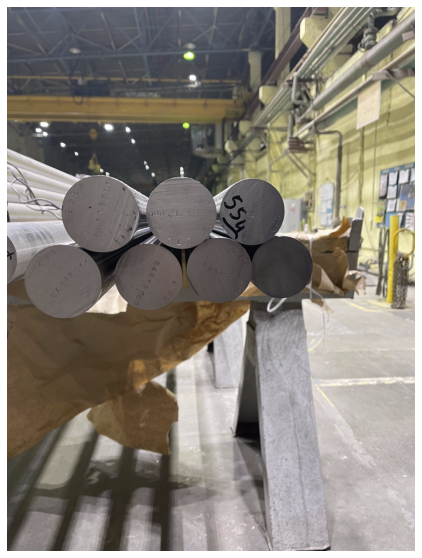

In [12]:
image = cv2.imread(os.path.join(CURR_DIR, 'img_examples/global_blurriness/positive/IMG_1748.png'))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image)

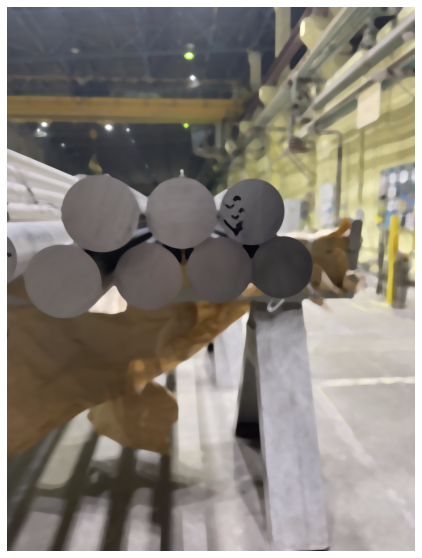

In [13]:
transform1 = A.MedianBlur(blur_limit=201, p=1.0)
random.seed(7)
augmented_image = transform1(image=image)['image']
visualize(augmented_image)

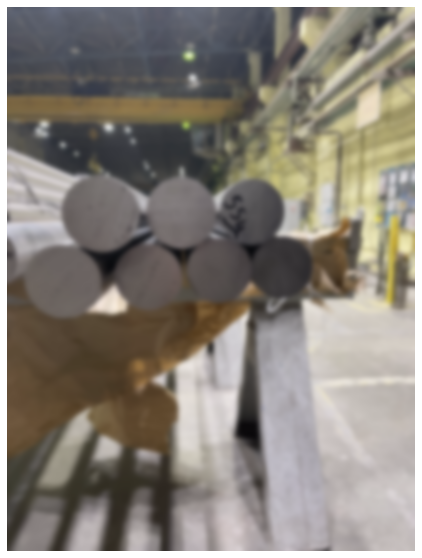

In [14]:
transform2 = A.GaussianBlur(blur_limit=(51, 201), p=1.0)
random.seed(7)
augmented_image = transform2(image=image)['image']
visualize(augmented_image)

In [35]:
for img in tqdm(os.listdir(POS_PATH)):
    curr_image = cv2.imread(os.path.join(POS_PATH, img))
    random.seed(7)
    augmented_image = transform1(image=curr_image)['image']
    cv2.imwrite(os.path.join(NEG_PATH, img + '_' + str(0)), augmented_image)
    random.seed(7)
    augmented_image = transform2(image=curr_image)['image']
    cv2.imwrite(os.path.join(NEG_PATH, img + '_' + str(1)), augmented_image)

  0%|          | 0/67 [00:00<?, ?it/s]

In [15]:
import scipy.ndimage as snd

def rgb_to_intensity(rgb_image):
    return np.dot(rgb_image[...,:3], [0.299, 0.587, 0.114])

def sta6_optimized(img: np.ndarray, conv_size: int = 0, stride: int = 1):
    image_intensity = rgb_to_intensity(img)
    
    mean_kernel = np.ones((conv_size, conv_size)) / conv_size**2
    image_mean_intensity = snd.convolve(image_intensity, mean_kernel)
    image_mean_intensity = image_mean_intensity[(conv_size-1)//2:image_mean_intensity.shape[0]-conv_size//2, (conv_size-1)//2:image_mean_intensity.shape[1]-conv_size//2]
    image_intensity = image_intensity[(conv_size-1)//2:image_intensity.shape[0]-conv_size//2, (conv_size-1)//2:image_intensity.shape[1]-conv_size//2]

    image_intensity = image_intensity[::stride, ::stride]
    image_mean_intensity = image_mean_intensity[::stride, ::stride]
    
    sta6 = np.mean(np.power(image_intensity - image_mean_intensity, 2))

    return sta6

In [20]:
import matplotlib.image as mpimg
from tqdm.notebook import tqdm

def count_sta6_on_images(path_to_images):
    values = []
    for i, img in tqdm(enumerate(os.listdir(path_to_images))):
        image = mpimg.imread(os.path.join(path_to_images, img))
        curr_val = sta6_optimized(image, conv_size=5)
        values.append(curr_val)
    return np.array(values)

negative_sta6 = count_sta6_on_images(NEG_PATH)
positive_sta6 = count_sta6_on_images(POS_PATH)

print('Positive examples: STA6')
print_statistics(positive_sta6)
print('Negative examples: STA6')
print_statistics(negative_sta6)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Positive examples: STA6
Min: 0.000, Max: 30.988
Mean: 9.210
0.02-quantile: 0.000, median: 9.734, 0.98-quantile: 20.105
Negative examples: STA6
Min: 0.000, Max: 17.746
Mean: 0.496
0.02-quantile: 0.000, median: 0.085, 0.98-quantile: 8.157


In [21]:
def sample_variance(gray_img: np.ndarray):
    return np.var(gray_img)

In [22]:
def count_metric_on_images(metric, path_to_images):
    values = []
    for i, img in tqdm(enumerate(os.listdir(path_to_images))):
        image = cv2.imread(os.path.join(path_to_images, img))
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        curr_val = metric(gray)
        values.append(curr_val)
    return np.array(values)

In [24]:
negative_var = count_metric_on_images(sample_variance, NEG_PATH)
positive_var = count_metric_on_images(sample_variance, POS_PATH)

print('Positive examples: variance')
print_statistics(positive_var)
print('Negative examples: variance')
print_statistics(negative_var)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Positive examples: variance
Min: 1151.716, Max: 4925.156
Mean: 2933.722
0.02-quantile: 1343.125, median: 2944.202, 0.98-quantile: 4677.895
Negative examples: variance
Min: 1075.152, Max: 4871.168
Mean: 2670.867
0.02-quantile: 1183.997, median: 2669.439, 0.98-quantile: 4521.686


In [27]:
from scipy.ndimage import convolve

def CONT(gray_img: np.ndarray):
    intensity = gray_img / 255
    kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    return np.mean(convolve(intensity, kernel)[1:-1, 1:-1])

In [28]:
negative_cont = count_metric_on_images(CONT, NEG_PATH)
positive_cont = count_metric_on_images(CONT, POS_PATH)

print('Positive examples: CONT')
print_statistics(positive_cont)
print('Negative examples: CONT')
print_statistics(negative_cont)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Positive examples: CONT
Min: 0.291, Max: 0.559
Mean: 0.479
0.02-quantile: 0.380, median: 0.483, 0.98-quantile: 0.551
Negative examples: CONT
Min: 0.288, Max: 0.561
Mean: 0.479
0.02-quantile: 0.378, median: 0.481, 0.98-quantile: 0.552


Видимо, метрика CONT не очень информативная в этой части

In [66]:
print('Positive examples: variance * STA6')
print_statistics(positive_var * (positive_sta6 + 1))
print('Negative examples: variance * STA6')
print_statistics(negative_var * (negative_sta6 + 1))

Positive examples: variance * STA6
Min: 2277.971, Max: 123890.142
Mean: 29429.050
0.02-quantile: 2817.010, median: 29579.077, 0.98-quantile: 76369.247
Negative examples: variance * STA6
Min: 1132.399, Max: 45233.316
Mean: 3869.483
0.02-quantile: 1284.489, median: 2972.851, 0.98-quantile: 16766.859


Пока не понятно, как отделять..:(

# Вторая проверка после детекции

Первым делом научимся запускать нашу сохранённую модель детекции (yolov5) на входной фотографии:

## Прутки на краях изображения

Сначала построим отрицательные примеры из датасета: